<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/saureus_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
!pip install pyforest
!pip install deepchem
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14605 sha256=9f541e940ff2ca6f5887fc08964102a48445175b9b2603187a4ad1a62da65806
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
      Successfully uninstalled scipy-1.11.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
from pyforest import*
lazy_imports() # load most libraries
import deepchem as dc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
import joblib
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from shap import Explanation
from shap.plots import waterfall
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Featurize smiles
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Saureus_clean.csv'
tasks = ['Saureus']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [4]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.20, random_state=42, stratify=dataset.y)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 1314   size of test set: 329



In [5]:
# Train SVC
svc = SVC(C=4.9635, kernel='rbf', gamma=8.862e-3, class_weight='balanced',
                probability=True, random_state=42)
svc.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

SVC(C=4.9635, class_weight='balanced', gamma=0.008862, probability=True,
    random_state=42)

In [6]:
# Train RF
rf = RandomForestClassifier(n_estimators=1182, criterion='entropy', max_depth=12,
                                      max_features='sqrt', class_weight='balanced',
                                      n_jobs=-1, random_state=42)
rf.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, n_estimators=1182, n_jobs=-1,
                       random_state=42)

In [7]:
# Train stacking model
stack = StackingClassifier(estimators=[('svc', svc), ('rf', rf)])

stack.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

StackingClassifier(estimators=[('svc',
                                SVC(C=4.9635, class_weight='balanced',
                                    gamma=0.008862, probability=True,
                                    random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=12,
                                                       n_estimators=1182,
                                                       n_jobs=-1,
                                                       random_state=42))])

In [8]:
# Evaluate the stacking model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(stack, X_train, np.ravel(y_train), cv=10, n_jobs=-1)
print("accuracy score: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score: {:.2f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("precision score: {:.2f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity score: {:.2f}".format(recall_score(y_train, y_train_pred)))
print("ROC-AUC: {:.2f}".format(roc_auc_score(y_train, y_train_pred)))
print("f1 score: {:.2f}".format(f1_score(y_train, y_train_pred)))
print("MCC score: {:.2f}".format(matthews_corrcoef(y_train, y_train_pred)))

Performance of evaluation metrics on training set


<IPython.core.display.Javascript object>

accuracy score: 0.81
kappa score: 0.60
precision score: 0.82
sensitivity score: 0.86
ROC-AUC: 0.80
f1 score: 0.84
MCC score: 0.60


In [9]:
# Save the model
joblib.dump(stack, "saureus.pkl")

['saureus.pkl']

In [10]:
# Load the model
saureus = joblib.load('saureus.pkl')

In [11]:
# Evaluate the stacking model on test set
y_pred = saureus.predict(X_test)
y_proba = saureus.predict_proba(X_test)[:, 1]
print("Performance of evaluation metrics on test set")
print("accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("kappa score: {:.2f}".format(cohen_kappa_score(y_test, y_pred)))
print("precision score: {:.2f}".format(precision_score(y_test, y_pred)))
print("sensitivity score: {:.2f}".format(recall_score(y_test, y_pred)))
print("ROC-AUC: {:.2f}".format(roc_auc_score(y_test, y_proba)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("MCC score: {:.2f}".format(matthews_corrcoef(y_test, y_pred)))

Performance of evaluation metrics on test set
accuracy score: 0.82
kappa score: 0.63
precision score: 0.84
sensitivity score: 0.87
ROC-AUC: 0.87
f1 score: 0.85
MCC score: 0.63


In [12]:
# Featurize own peptides
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Saureus_test.csv'
tasks = ['Saureus']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [13]:
# Convert dataset.X to dataframe
X = pd.DataFrame(dataset.X)
col = ['ECFP' + str(x) for x in range(0,2048)]
X.columns = col
X.head()

<IPython.core.display.Javascript object>

,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,...,ECFP2038,ECFP2039,ECFP2040,ECFP2041,ECFP2042,ECFP2043,ECFP2044,ECFP2045,ECFP2046,ECFP2047
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Predict activity of own peptides
pred = saureus.predict(X)
pred

X has feature names, but SVC was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

**Feature importance**

In [15]:
# SHAP values
explainer = shap.KernelExplainer(saureus.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/11 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


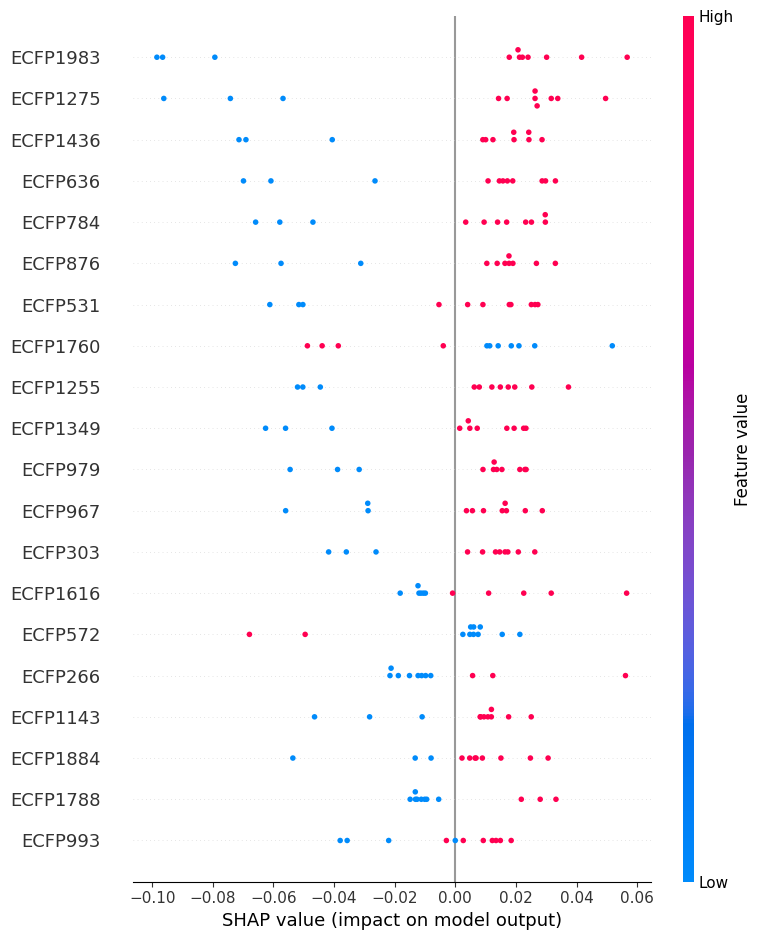

In [16]:
shap.summary_plot(shap_values, X)

Example: C14-ano-NH2

In [17]:
# Plot the SHAP values for the 1st observation as force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

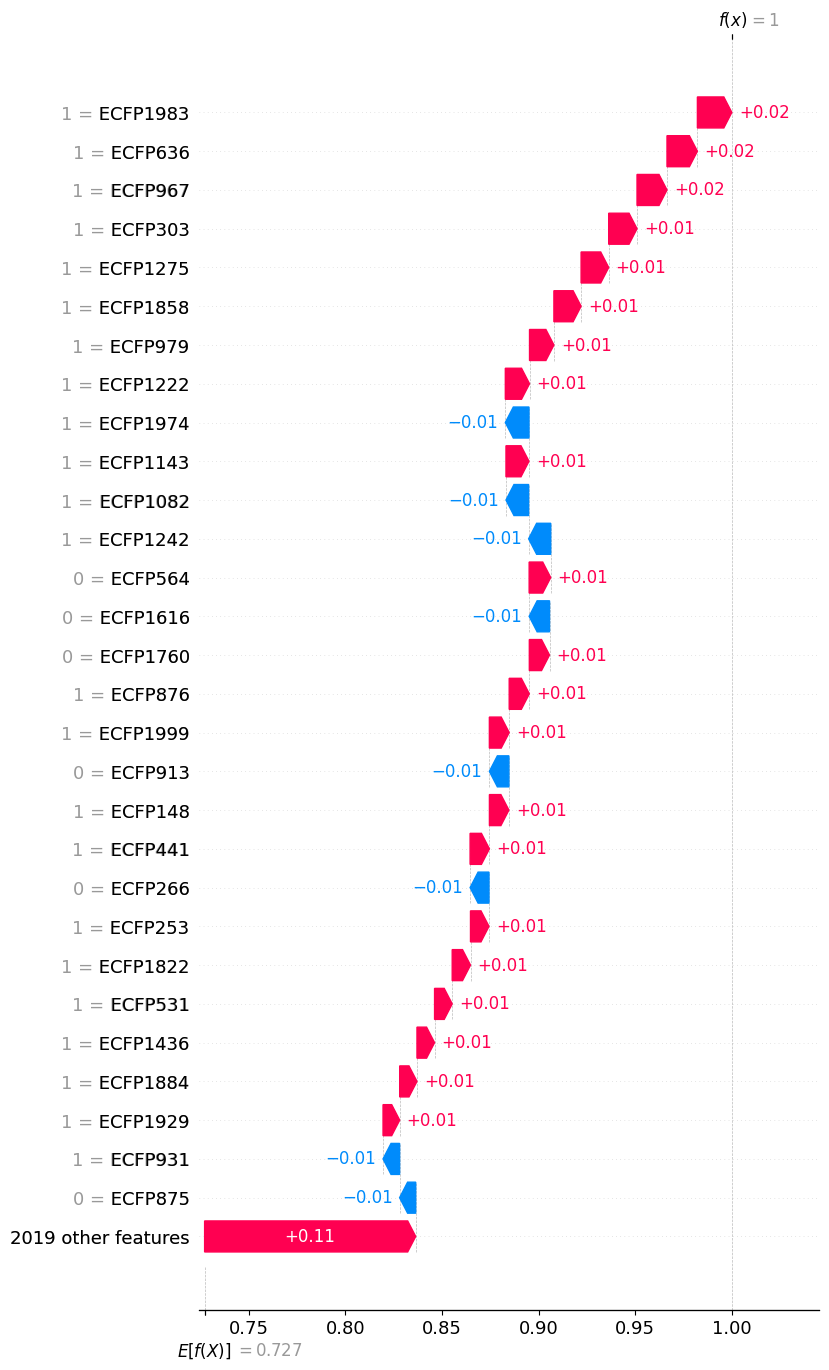

In [18]:
# Plot the SHAP values for the 1st observation as waterfall
exp = Explanation(shap_values, explainer.expected_value, data=X.loc[[0]].values, feature_names=X.columns)
waterfall(exp[0], max_display=30)

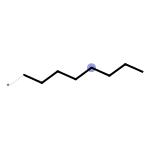

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
mol = Chem.MolFromSmiles('CCCCCCCCCCCCCC(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(N)=O)[C@@H](C)O')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=6, bitInfo=bi, nBits=2048)
bi[1275]
mfp1 = Draw.DrawMorganBit(mol, 1275, bi, useSVG=True)
mfp1

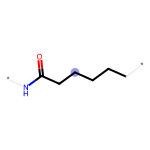

In [24]:
bi[967]
mfp2 = Draw.DrawMorganBit(mol, 967, bi, useSVG=True)
mfp2

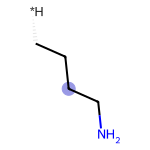

In [23]:
bi[1082]
mfp3 = Draw.DrawMorganBit(mol, 1082, bi, useSVG=True)
mfp3